<a href="https://colab.research.google.com/github/ClarisseAlvarenga/codenation_aceleradev_ds/blob/master/Desafio_Codenation_Semana_09.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# DESAFIO - QUEM ESTÁ FAZENDO O ENEM SÓ PARA TREINO?



**Detalhes**

O contexto do desafio gira em torno dos resultados do ENEM 2016 (disponíveis no arquivo train.csv). Este arquivo, e apenas ele, deve ser utilizado para todos os desafios. Qualquer dúvida a respeito das colunas, consulte o Dicionário dos Microdados do Enem 2016.

Alguns estudantes decidem realizar prova do ENEM de forma precoce, como um teste (coluna IN_TREINEIRO). Neste desafio, você deve criar um modelo de classificação binária para inferir a mesma. Os resultados possíveis da sua resposta devem ser “0” ou “1”.

Salve sua resposta em um arquivo chamado answer.csv com duas colunas: NU_INSCRICAO e IN_TREINEIRO.

## IMPORTANDO AS BIBLIOTECAS

In [242]:
#USANDO AS BIBLIOTECAS DO NOTEBOOK DA CODENATION
import functools
from math import sqrt

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import statsmodels.api as sm
import scipy.stats as sct
import seaborn as sns
from imblearn.over_sampling import SMOTE
from sklearn.datasets import make_blobs, make_classification
from sklearn.decomposition import PCA
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier, plot_tree

## ANÁLISE EXPLORATÓRIA

In [243]:
#definindo uma seed
np.random.seed(1000)

In [244]:
#Conhecendo o DATASET de Treino
treino = pd.read_csv('train.csv')

In [245]:
treino.head()

,Unnamed: 0,NU_INSCRICAO,NU_ANO,CO_MUNICIPIO_RESIDENCIA,NO_MUNICIPIO_RESIDENCIA,CO_UF_RESIDENCIA,SG_UF_RESIDENCIA,NU_IDADE,TP_SEXO,TP_ESTADO_CIVIL,TP_COR_RACA,TP_NACIONALIDADE,CO_MUNICIPIO_NASCIMENTO,NO_MUNICIPIO_NASCIMENTO,CO_UF_NASCIMENTO,SG_UF_NASCIMENTO,TP_ST_CONCLUSAO,TP_ANO_CONCLUIU,TP_ESCOLA,TP_ENSINO,IN_TREINEIRO,CO_ESCOLA,CO_MUNICIPIO_ESC,NO_MUNICIPIO_ESC,CO_UF_ESC,SG_UF_ESC,TP_DEPENDENCIA_ADM_ESC,TP_LOCALIZACAO_ESC,TP_SIT_FUNC_ESC,IN_BAIXA_VISAO,IN_CEGUEIRA,IN_SURDEZ,IN_DEFICIENCIA_AUDITIVA,IN_SURDO_CEGUEIRA,IN_DEFICIENCIA_FISICA,IN_DEFICIENCIA_MENTAL,IN_DEFICIT_ATENCAO,IN_DISLEXIA,IN_DISCALCULIA,IN_AUTISMO,...,Q011,Q012,Q013,Q014,Q015,Q016,Q017,Q018,Q019,Q020,Q021,Q022,Q023,Q024,Q025,Q026,Q027,Q028,Q029,Q030,Q031,Q032,Q033,Q034,Q035,Q036,Q037,Q038,Q039,Q040,Q041,Q042,Q043,Q044,Q045,Q046,Q047,Q048,Q049,Q050
0,1,ed50e8aaa58e7a806c337585efee9ca41f1eb1ad,2016,4314902,Porto Alegre,43,RS,24,M,0.0,1,1,4314902.0,Porto Alegre,43.0,RS,1,4,1,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0,0,0,0,0,0,0,0,0,0,...,A,B,A,A,A,A,A,A,B,A,A,C,A,A,A,C,H,E,5.0,5.0,1.0,0.0,0.0,5,5,0,5,5,5,5,5.0,A,A,A,A,A,A,A,B,D
1,2,2c3acac4b33ec2b195d77e7c04a2d75727fad723,2016,2304707,Granja,23,CE,17,F,0.0,3,1,2304707.0,Granja,23.0,CE,2,0,2,1.0,0,23005157.0,2304707.0,Granja,23.0,CE,2.0,1.0,1.0,0,0,0,0,0,0,0,0,0,0,0,...,A,B,A,A,A,A,A,A,B,A,A,A,A,A,A,A,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5,5,1,1,1,1,1,NaN,A,A,C,A,B,A,A,C,A
2,3,f4545f8ccb9ff5c8aad7d32951b3f251a26e6568,2016,2304400,Fortaleza,23,CE,21,F,0.0,3,1,2304400.0,Fortaleza,23.0,CE,3,0,1,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0,0,0,0,0,0,0,0,0,0,...,A,B,A,A,A,A,A,A,B,A,A,B,A,A,A,A,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5,5,5,5,5,5,5,NaN,A,A,A,A,C,A,A,B,A
3,4,3d6ec248fef899c414e77f82d5c6d2bffbeaf7fe,2016,3304557,Rio de Janeiro,33,RJ,25,F,0.0,0,1,3304557.0,Rio de Janeiro,33.0,RJ,1,9,1,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0,0,0,0,0,0,0,0,0,0,...,A,B,B,B,A,B,A,B,C,A,B,D,B,C,B,C,F,C,2.0,0.0,5.0,5.0,5.0,5,5,5,5,2,5,5,5.0,C,A,A,A,A,D,A,A,A
4,5,bf896ac8d3ecadd6dba1dfbf50110afcbf5d3268,2016,1302603,Manaus,13,AM,28,M,0.0,2,1,1505304.0,Oriximiná,15.0,PA,1,4,1,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0,0,0,0,0,0,0,0,0,0,...,A,B,A,B,A,A,A,A,B,A,A,B,A,A,A,B,F,D,5.0,4.0,3.0,5.0,4.0,5,5,4,3,1,4,5,NaN,A,A,A,A,A,A,A,A,A


In [246]:
#tamanho do arquivo
treino.shape

(13730, 167)

In [247]:
#informações
treino.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13730 entries, 0 to 13729
Columns: 167 entries, Unnamed: 0 to Q050
dtypes: float64(28), int64(79), object(60)
memory usage: 17.5+ MB


In [248]:
#nulos
treino.isna().sum().sum()

253786

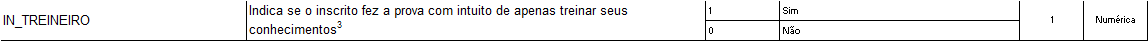

In [249]:
#conferindo a coluna de treineiros
treino['IN_TREINEIRO'].value_counts(normalize=True)


0    0.870138
1    0.129862
Name: IN_TREINEIRO, dtype: float64

In [250]:
#conferindo a base de testes
teste = pd.read_csv('test.csv')

In [251]:
teste.head()

,NU_INSCRICAO,CO_UF_RESIDENCIA,SG_UF_RESIDENCIA,NU_IDADE,TP_SEXO,TP_COR_RACA,TP_NACIONALIDADE,TP_ST_CONCLUSAO,TP_ANO_CONCLUIU,TP_ESCOLA,TP_ENSINO,TP_DEPENDENCIA_ADM_ESC,IN_BAIXA_VISAO,IN_CEGUEIRA,IN_SURDEZ,IN_DISLEXIA,IN_DISCALCULIA,IN_SABATISTA,IN_GESTANTE,IN_IDOSO,TP_PRESENCA_CN,TP_PRESENCA_CH,TP_PRESENCA_LC,TP_PRESENCA_MT,NU_NOTA_CN,NU_NOTA_CH,NU_NOTA_LC,TP_LINGUA,TP_STATUS_REDACAO,NU_NOTA_COMP1,NU_NOTA_COMP2,NU_NOTA_COMP3,NU_NOTA_COMP4,NU_NOTA_COMP5,NU_NOTA_REDACAO,Q001,Q002,Q006,Q024,Q025,Q026,Q027,Q047
0,ba0cc30ba34e7a46764c09dfc38ed83d15828897,43,RS,19,F,1,1,1,3,1,NaN,NaN,0,0,0,0,0,0,0,0,1,1,0,0,495.3,593.3,NaN,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,E,E,H,B,B,C,D,A
1,177f281c68fa032aedbd842a745da68490926cd2,15,PA,24,M,3,2,1,4,1,NaN,NaN,0,0,0,0,0,0,0,0,0,0,0,0,NaN,NaN,NaN,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,B,C,B,A,A,C,D,A
2,6cf0d8b97597d7625cdedc7bdb6c0f052286c334,29,BA,16,F,2,1,3,0,1,NaN,NaN,0,0,0,0,0,0,0,0,1,1,0,0,559.1,529.3,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,E,F,G,B,B,A,NaN,D
3,5c356d810fa57671402502cd0933e5601a2ebf1e,41,PR,17,F,1,1,2,0,2,1.0,2.0,0,0,0,0,0,0,0,0,1,1,1,1,475.0,557.8,542.0,1,1.0,120.0,120.0,80.0,120.0,40.0,480.0,E,E,E,C,B,B,C,A
4,df47c07bd881c2db3f38c6048bf77c132ad0ceb3,53,DF,19,F,1,1,1,1,1,NaN,NaN,0,0,0,0,0,0,0,0,1,1,1,1,440.5,596.1,594.2,1,1.0,160.0,160.0,160.0,160.0,80.0,720.0,E,E,E,B,B,B,D,A


In [252]:
#transformando as colunas do teste em uma lista para aplicar no df de treino
colunas_teste = list(teste.columns)
print(colunas_teste)
print(len(colunas_teste))

['NU_INSCRICAO', 'CO_UF_RESIDENCIA', 'SG_UF_RESIDENCIA', 'NU_IDADE', 'TP_SEXO', 'TP_COR_RACA', 'TP_NACIONALIDADE', 'TP_ST_CONCLUSAO', 'TP_ANO_CONCLUIU', 'TP_ESCOLA', 'TP_ENSINO', 'TP_DEPENDENCIA_ADM_ESC', 'IN_BAIXA_VISAO', 'IN_CEGUEIRA', 'IN_SURDEZ', 'IN_DISLEXIA', 'IN_DISCALCULIA', 'IN_SABATISTA', 'IN_GESTANTE', 'IN_IDOSO', 'TP_PRESENCA_CN', 'TP_PRESENCA_CH', 'TP_PRESENCA_LC', 'TP_PRESENCA_MT', 'NU_NOTA_CN', 'NU_NOTA_CH', 'NU_NOTA_LC', 'TP_LINGUA', 'TP_STATUS_REDACAO', 'NU_NOTA_COMP1', 'NU_NOTA_COMP2', 'NU_NOTA_COMP3', 'NU_NOTA_COMP4', 'NU_NOTA_COMP5', 'NU_NOTA_REDACAO', 'Q001', 'Q002', 'Q006', 'Q024', 'Q025', 'Q026', 'Q027', 'Q047']
43


In [253]:
# incluindo a variável dependente (IN_TREINEIRO)
colunas_teste.append('IN_TREINEIRO')
print(colunas_teste)
print(len(colunas_teste))

['NU_INSCRICAO', 'CO_UF_RESIDENCIA', 'SG_UF_RESIDENCIA', 'NU_IDADE', 'TP_SEXO', 'TP_COR_RACA', 'TP_NACIONALIDADE', 'TP_ST_CONCLUSAO', 'TP_ANO_CONCLUIU', 'TP_ESCOLA', 'TP_ENSINO', 'TP_DEPENDENCIA_ADM_ESC', 'IN_BAIXA_VISAO', 'IN_CEGUEIRA', 'IN_SURDEZ', 'IN_DISLEXIA', 'IN_DISCALCULIA', 'IN_SABATISTA', 'IN_GESTANTE', 'IN_IDOSO', 'TP_PRESENCA_CN', 'TP_PRESENCA_CH', 'TP_PRESENCA_LC', 'TP_PRESENCA_MT', 'NU_NOTA_CN', 'NU_NOTA_CH', 'NU_NOTA_LC', 'TP_LINGUA', 'TP_STATUS_REDACAO', 'NU_NOTA_COMP1', 'NU_NOTA_COMP2', 'NU_NOTA_COMP3', 'NU_NOTA_COMP4', 'NU_NOTA_COMP5', 'NU_NOTA_REDACAO', 'Q001', 'Q002', 'Q006', 'Q024', 'Q025', 'Q026', 'Q027', 'Q047', 'IN_TREINEIRO']
44


In [254]:
#atribuindo a uma nova variável a seleção das colunas disponíveis no teste no df de treino. Chamarei de dados daqui em diante
dados = treino[colunas_teste]

In [255]:
dados.head()

,NU_INSCRICAO,CO_UF_RESIDENCIA,SG_UF_RESIDENCIA,NU_IDADE,TP_SEXO,TP_COR_RACA,TP_NACIONALIDADE,TP_ST_CONCLUSAO,TP_ANO_CONCLUIU,TP_ESCOLA,TP_ENSINO,TP_DEPENDENCIA_ADM_ESC,IN_BAIXA_VISAO,IN_CEGUEIRA,IN_SURDEZ,IN_DISLEXIA,IN_DISCALCULIA,IN_SABATISTA,IN_GESTANTE,IN_IDOSO,TP_PRESENCA_CN,TP_PRESENCA_CH,TP_PRESENCA_LC,TP_PRESENCA_MT,NU_NOTA_CN,NU_NOTA_CH,NU_NOTA_LC,TP_LINGUA,TP_STATUS_REDACAO,NU_NOTA_COMP1,NU_NOTA_COMP2,NU_NOTA_COMP3,NU_NOTA_COMP4,NU_NOTA_COMP5,NU_NOTA_REDACAO,Q001,Q002,Q006,Q024,Q025,Q026,Q027,Q047,IN_TREINEIRO
0,ed50e8aaa58e7a806c337585efee9ca41f1eb1ad,43,RS,24,M,1,1,1,4,1,NaN,NaN,0,0,0,0,0,0,0,0,1,1,1,1,436.3,495.4,581.2,1,1.0,120.0,120.0,120.0,80.0,80.0,520.0,D,D,C,A,A,C,H,A,0
1,2c3acac4b33ec2b195d77e7c04a2d75727fad723,23,CE,17,F,3,1,2,0,2,1.0,2.0,0,0,0,0,0,0,0,0,1,1,1,1,474.5,544.1,599.0,1,1.0,140.0,120.0,120.0,120.0,80.0,580.0,A,A,B,A,A,A,NaN,A,0
2,f4545f8ccb9ff5c8aad7d32951b3f251a26e6568,23,CE,21,F,3,1,3,0,1,NaN,NaN,0,0,0,0,0,0,0,0,0,0,0,0,NaN,NaN,NaN,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,D,D,C,A,A,A,NaN,A,0
3,3d6ec248fef899c414e77f82d5c6d2bffbeaf7fe,33,RJ,25,F,0,1,1,9,1,NaN,NaN,0,0,0,0,0,0,0,0,0,0,0,0,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,H,E,E,C,B,C,F,D,0
4,bf896ac8d3ecadd6dba1dfbf50110afcbf5d3268,13,AM,28,M,2,1,1,4,1,NaN,NaN,0,0,0,0,0,0,0,0,0,0,0,0,NaN,NaN,NaN,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,E,D,C,A,A,B,F,A,0


In [256]:
dados.shape

(13730, 44)

In [257]:
#conferindo as informações
dados.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13730 entries, 0 to 13729
Data columns (total 44 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   NU_INSCRICAO            13730 non-null  object 
 1   CO_UF_RESIDENCIA        13730 non-null  int64  
 2   SG_UF_RESIDENCIA        13730 non-null  object 
 3   NU_IDADE                13730 non-null  int64  
 4   TP_SEXO                 13730 non-null  object 
 5   TP_COR_RACA             13730 non-null  int64  
 6   TP_NACIONALIDADE        13730 non-null  int64  
 7   TP_ST_CONCLUSAO         13730 non-null  int64  
 8   TP_ANO_CONCLUIU         13730 non-null  int64  
 9   TP_ESCOLA               13730 non-null  int64  
 10  TP_ENSINO               4282 non-null   float64
 11  TP_DEPENDENCIA_ADM_ESC  4282 non-null   float64
 12  IN_BAIXA_VISAO          13730 non-null  int64  
 13  IN_CEGUEIRA             13730 non-null  int64  
 14  IN_SURDEZ               13730 non-null

## PRIMEIRA HIPÓTESE NULA: A MÉDIA DOS TREINEIROS NA NOTA DE REDAÇÃO É A MESMA DOS QUE ESTÃO FAZENDO PARA VALER!

In [258]:
#DIVIDINDO OS DATASETS
dados_treineiro = dados.query('IN_TREINEIRO == 1')
dados_oficial = dados.query('IN_TREINEIRO == 0')

In [259]:
dados_treineiro.shape

(1783, 44)

In [260]:
dados_oficial.shape


(11947, 44)

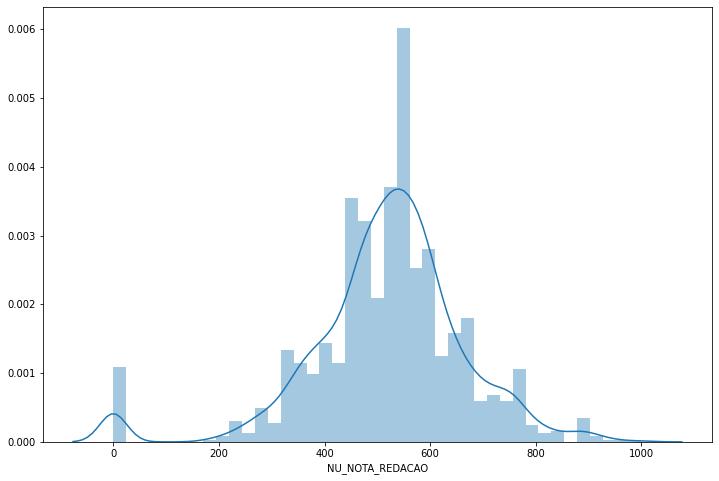

In [261]:
#visualizando a distribuição das notas de redação entre treineiros
plt.figure(figsize = (12,8))
ax = sns.distplot(dados_treineiro['NU_NOTA_REDACAO'])

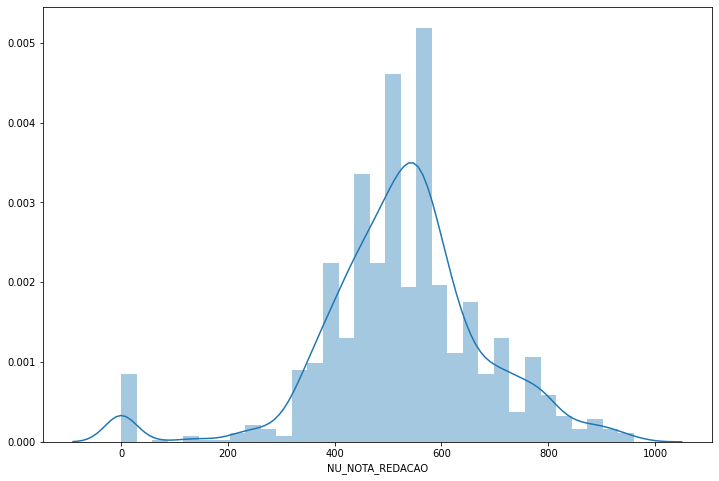

In [262]:
#visualizando a distribuição das notas de redação entre não treineiros
plt.figure(figsize = (12,8))
ax = sns.distplot(dados_oficial['NU_NOTA_REDACAO'].sample(1783))

In [263]:
#conferindo usando as estatísticas descritivas
from scipy.stats import ttest_ind
from statsmodels.stats.weightstats import zconfint, DescrStatsW, ztest

In [264]:
#conferindo se a média das notas de redação dos treineiros é igual à média geral
treineiros = DescrStatsW(dados_treineiro['NU_NOTA_REDACAO'].dropna())
total = DescrStatsW(dados['NU_NOTA_REDACAO'].dropna())

In [265]:
comparacao = treineiros.get_compare(total)

In [266]:
#podemos descartar que fazem parte da mesma distribuição
print(comparacao.summary())

                          Test for equality of means                          
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
subset #1     -9.7260      4.243     -2.292      0.022     -18.044      -1.408


In [267]:
#com os oficiais agora
oficiais = total = DescrStatsW(dados_oficial['NU_NOTA_REDACAO'].dropna())

In [269]:
#podemos descartar a hipótese nula
comparacao = treineiros.get_compare(oficiais)
print(comparacao.summary())

                          Test for equality of means                          
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
subset #1    -11.4225      4.309     -2.651      0.008     -19.869      -2.976


### Fazendo tabelas cruzadas usando a média da nota de redação como parâmetro

In [270]:
#dicionário para renomear as colunas_teste
sexo = {'M':'Masculino',
        'F':'Feminino'}
conclusao = {1:'concluido',
       2:'conclui em 2016',
       3:'conclui apos 2016',
       4:'não cursando',
       }
treineiro = {0: 'Não', 1: 'Sim'}
escola={1:'Não Respondeu', 2:'Pública', 3:'Privada',4:'Exterior'}
presenca = {0:'Faltou',1: 'Presente', 2:'Eliminado'}

In [271]:
#por situação de conclusão de curso
pd.crosstab(dados.IN_TREINEIRO, dados.TP_ST_CONCLUSAO, aggfunc= 'mean', values=dados.NU_NOTA_REDACAO).rename(columns=conclusao, index=treineiro)

TP_ST_CONCLUSAO,concluido,conclui em 2016,conclui apos 2016,não cursando
IN_TREINEIRO,,,,
Não,543.293468,531.983516,426.645714,452.689655
Sim,NaN,NaN,519.322259,NaN


In [272]:
#por sexo
pd.crosstab(dados.IN_TREINEIRO, dados.TP_SEXO, aggfunc='mean', values=dados.NU_NOTA_REDACAO).rename(index=treineiro, columns=sexo)


TP_SEXO,Feminino,Masculino
IN_TREINEIRO,,
Não,540.049336,516.142347
Sim,534.429869,490.194553


In [273]:
#por estado
pd.crosstab(dados.SG_UF_RESIDENCIA, dados.IN_TREINEIRO, aggfunc='mean', values=dados.NU_NOTA_REDACAO).rename(columns=treineiro)

IN_TREINEIRO,Não,Sim
SG_UF_RESIDENCIA,,
AC,490.212766,740.000000
AL,526.329114,604.000000
AM,508.129032,516.250000
AP,500.392157,400.000000
BA,513.807829,531.650485
CE,499.892009,478.878924
DF,554.939597,546.153846
ES,543.744681,569.565217
GO,524.852459,526.493506


In [274]:
#por estado sem a aggfunc
pd.crosstab(dados.SG_UF_RESIDENCIA, dados.IN_TREINEIRO).rename(columns=treineiro)


IN_TREINEIRO,Não,Sim
SG_UF_RESIDENCIA,,
AC,64,3
AL,199,11
AM,250,24
AP,70,3
BA,792,120
CE,1266,519
DF,218,14
ES,245,27
GO,410,92


In [275]:
#por tipo de ensino
pd.crosstab(dados.IN_TREINEIRO, dados.TP_ESCOLA).rename(index=treineiro, columns=escola)

TP_ESCOLA,Não Respondeu,Pública,Privada,Exterior
IN_TREINEIRO,,,,
Não,7664,3713,569,1
Sim,1783,0,0,0


In [276]:
#por presença nas provas de Ciências Naturais
pd.crosstab(dados.IN_TREINEIRO, dados.TP_PRESENCA_CN).rename(index=treineiro, columns=presenca)
         

TP_PRESENCA_CN,Faltou,Presente,Eliminado
IN_TREINEIRO,,,
Não,3130,8809,8
Sim,250,1532,1


In [277]:
#por presença nas provas de Linguagem e Código
pd.crosstab(dados.IN_TREINEIRO, dados.TP_PRESENCA_LC).rename(index=treineiro, columns=presenca)


TP_PRESENCA_LC,Faltou,Presente,Eliminado
IN_TREINEIRO,,,
Não,3314,8628,5
Sim,278,1505,0


In [278]:
#visualizando o percentual de pessoas que faltaram no total
3314/(8628+3314+5)

0.2773918138444798

In [281]:
#visualizando o percentual de treineiros faltantes
278/1783

0.15591699383062255

In [284]:
#conferindo se a presença dos treineiros é igual à média geral
treineiros = DescrStatsW(dados_treineiro['TP_PRESENCA_CN'].dropna())
total = DescrStatsW(dados['TP_PRESENCA_CN'].dropna())

In [285]:
#podemos descartar a hipótese nula
print(treineiros.get_compare(total).summary())

                          Test for equality of means                          
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
subset #1      0.1059      0.011      9.938      0.000       0.085       0.127


In [286]:
#conferindo se a presença dos treineiros é igual à aos que fazem pra valer
oficiais = DescrStatsW(dados_oficial['TP_PRESENCA_CN'].dropna())

In [287]:
#podemos descartar a hipótese nula
print(treineiros.get_compare(oficiais).summary())

                          Test for equality of means                          
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
subset #1      0.1217      0.011     11.145      0.000       0.100       0.143


### MANIPULANDO OS DADOS


In [288]:
#COLOCANDO A INSCRIÇÃO COMO INDEX
dados.set_index('NU_INSCRICAO', inplace=True)

In [289]:
dados.head()

,CO_UF_RESIDENCIA,SG_UF_RESIDENCIA,NU_IDADE,TP_SEXO,TP_COR_RACA,TP_NACIONALIDADE,TP_ST_CONCLUSAO,TP_ANO_CONCLUIU,TP_ESCOLA,TP_ENSINO,TP_DEPENDENCIA_ADM_ESC,IN_BAIXA_VISAO,IN_CEGUEIRA,IN_SURDEZ,IN_DISLEXIA,IN_DISCALCULIA,IN_SABATISTA,IN_GESTANTE,IN_IDOSO,TP_PRESENCA_CN,TP_PRESENCA_CH,TP_PRESENCA_LC,TP_PRESENCA_MT,NU_NOTA_CN,NU_NOTA_CH,NU_NOTA_LC,TP_LINGUA,TP_STATUS_REDACAO,NU_NOTA_COMP1,NU_NOTA_COMP2,NU_NOTA_COMP3,NU_NOTA_COMP4,NU_NOTA_COMP5,NU_NOTA_REDACAO,Q001,Q002,Q006,Q024,Q025,Q026,Q027,Q047,IN_TREINEIRO
NU_INSCRICAO,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
ed50e8aaa58e7a806c337585efee9ca41f1eb1ad,43,RS,24,M,1,1,1,4,1,NaN,NaN,0,0,0,0,0,0,0,0,1,1,1,1,436.3,495.4,581.2,1,1.0,120.0,120.0,120.0,80.0,80.0,520.0,D,D,C,A,A,C,H,A,0
2c3acac4b33ec2b195d77e7c04a2d75727fad723,23,CE,17,F,3,1,2,0,2,1.0,2.0,0,0,0,0,0,0,0,0,1,1,1,1,474.5,544.1,599.0,1,1.0,140.0,120.0,120.0,120.0,80.0,580.0,A,A,B,A,A,A,NaN,A,0
f4545f8ccb9ff5c8aad7d32951b3f251a26e6568,23,CE,21,F,3,1,3,0,1,NaN,NaN,0,0,0,0,0,0,0,0,0,0,0,0,NaN,NaN,NaN,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,D,D,C,A,A,A,NaN,A,0
3d6ec248fef899c414e77f82d5c6d2bffbeaf7fe,33,RJ,25,F,0,1,1,9,1,NaN,NaN,0,0,0,0,0,0,0,0,0,0,0,0,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,H,E,E,C,B,C,F,D,0
bf896ac8d3ecadd6dba1dfbf50110afcbf5d3268,13,AM,28,M,2,1,1,4,1,NaN,NaN,0,0,0,0,0,0,0,0,0,0,0,0,NaN,NaN,NaN,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,E,D,C,A,A,B,F,A,0


In [290]:
#REAJUSTANDO AS COLUNAS DE TESTE PARA CONTER APENAS DADOS NUMÉRICOS

dados_numericos = dados.select_dtypes(include='number')

In [291]:
dados_numericos

,CO_UF_RESIDENCIA,NU_IDADE,TP_COR_RACA,TP_NACIONALIDADE,TP_ST_CONCLUSAO,TP_ANO_CONCLUIU,TP_ESCOLA,TP_ENSINO,TP_DEPENDENCIA_ADM_ESC,IN_BAIXA_VISAO,IN_CEGUEIRA,IN_SURDEZ,IN_DISLEXIA,IN_DISCALCULIA,IN_SABATISTA,IN_GESTANTE,IN_IDOSO,TP_PRESENCA_CN,TP_PRESENCA_CH,TP_PRESENCA_LC,TP_PRESENCA_MT,NU_NOTA_CN,NU_NOTA_CH,NU_NOTA_LC,TP_LINGUA,TP_STATUS_REDACAO,NU_NOTA_COMP1,NU_NOTA_COMP2,NU_NOTA_COMP3,NU_NOTA_COMP4,NU_NOTA_COMP5,NU_NOTA_REDACAO,IN_TREINEIRO
NU_INSCRICAO,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
ed50e8aaa58e7a806c337585efee9ca41f1eb1ad,43,24,1,1,1,4,1,NaN,NaN,0,0,0,0,0,0,0,0,1,1,1,1,436.3,495.4,581.2,1,1.0,120.0,120.0,120.0,80.0,80.0,520.0,0
2c3acac4b33ec2b195d77e7c04a2d75727fad723,23,17,3,1,2,0,2,1.0,2.0,0,0,0,0,0,0,0,0,1,1,1,1,474.5,544.1,599.0,1,1.0,140.0,120.0,120.0,120.0,80.0,580.0,0
f4545f8ccb9ff5c8aad7d32951b3f251a26e6568,23,21,3,1,3,0,1,NaN,NaN,0,0,0,0,0,0,0,0,0,0,0,0,NaN,NaN,NaN,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
3d6ec248fef899c414e77f82d5c6d2bffbeaf7fe,33,25,0,1,1,9,1,NaN,NaN,0,0,0,0,0,0,0,0,0,0,0,0,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
bf896ac8d3ecadd6dba1dfbf50110afcbf5d3268,13,28,2,1,1,4,1,NaN,NaN,0,0,0,0,0,0,0,0,0,0,0,0,NaN,NaN,NaN,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
aadf671ef8c1c6efa42e69432093ab83c17a52ac,35,20,1,1,1,3,1,NaN,NaN,0,0,0,0,0,0,0,0,1,1,1,1,438.2,419.7,394.5,0,1.0,120.0,120.0,80.0,80.0,40.0,440.0,0
461f7ef2753d9d5fa0b054930d6b0e0eec318e81,26,33,3,2,1,10,1,NaN,NaN,0,0,0,0,0,0,0,0,1,1,1,1,423.8,557.9,533.0,1,1.0,120.0,120.0,120.0,120.0,80.0,560.0,0
5354503700ecf2388f68990435390b6e1ad454ee,43,15,1,1,3,0,1,NaN,NaN,0,0,0,0,0,0,0,0,1,1,1,1,460.5,528.9,569.3,0,1.0,120.0,120.0,120.0,120.0,120.0,600.0,1


In [292]:
#TRATANDOS OS NULOS IMPUTANDO UM NÚMERO NEGATIVO
dados_tratados = dados_numericos.fillna(-1)
dados_tratados.head()

,CO_UF_RESIDENCIA,NU_IDADE,TP_COR_RACA,TP_NACIONALIDADE,TP_ST_CONCLUSAO,TP_ANO_CONCLUIU,TP_ESCOLA,TP_ENSINO,TP_DEPENDENCIA_ADM_ESC,IN_BAIXA_VISAO,IN_CEGUEIRA,IN_SURDEZ,IN_DISLEXIA,IN_DISCALCULIA,IN_SABATISTA,IN_GESTANTE,IN_IDOSO,TP_PRESENCA_CN,TP_PRESENCA_CH,TP_PRESENCA_LC,TP_PRESENCA_MT,NU_NOTA_CN,NU_NOTA_CH,NU_NOTA_LC,TP_LINGUA,TP_STATUS_REDACAO,NU_NOTA_COMP1,NU_NOTA_COMP2,NU_NOTA_COMP3,NU_NOTA_COMP4,NU_NOTA_COMP5,NU_NOTA_REDACAO,IN_TREINEIRO
NU_INSCRICAO,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
ed50e8aaa58e7a806c337585efee9ca41f1eb1ad,43,24,1,1,1,4,1,-1.0,-1.0,0,0,0,0,0,0,0,0,1,1,1,1,436.3,495.4,581.2,1,1.0,120.0,120.0,120.0,80.0,80.0,520.0,0
2c3acac4b33ec2b195d77e7c04a2d75727fad723,23,17,3,1,2,0,2,1.0,2.0,0,0,0,0,0,0,0,0,1,1,1,1,474.5,544.1,599.0,1,1.0,140.0,120.0,120.0,120.0,80.0,580.0,0
f4545f8ccb9ff5c8aad7d32951b3f251a26e6568,23,21,3,1,3,0,1,-1.0,-1.0,0,0,0,0,0,0,0,0,0,0,0,0,-1.0,-1.0,-1.0,1,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,0
3d6ec248fef899c414e77f82d5c6d2bffbeaf7fe,33,25,0,1,1,9,1,-1.0,-1.0,0,0,0,0,0,0,0,0,0,0,0,0,-1.0,-1.0,-1.0,0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,0
bf896ac8d3ecadd6dba1dfbf50110afcbf5d3268,13,28,2,1,1,4,1,-1.0,-1.0,0,0,0,0,0,0,0,0,0,0,0,0,-1.0,-1.0,-1.0,1,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,0


In [293]:
corr = dados_tratados.corr()

In [294]:
#função para criar heatmap
def criar_heatmap(corr):
  # Generate a mask for the upper triangle
  mask = np.triu(np.ones_like(corr, dtype=np.bool))

  # Set up the matplotlib figure
  f, ax = plt.subplots(figsize=(11, 9))

  # Generate a custom diverging colormap
  cmap = sns.diverging_palette(220, 10, as_cmap=True)

  # Draw the heatmap with the mask and correct aspect ratio
  sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5}, annot=False)

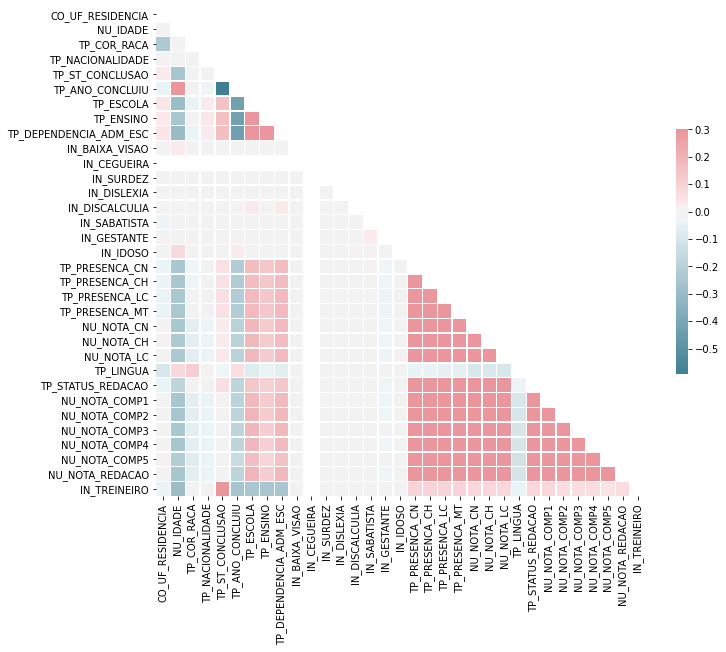

In [295]:
#criando um heatmap
criar_heatmap(corr)

## APLICANDO UM MODELO SEM SELEÇÃO DE FEATURES ALÉM DA LIMPEZA DAS FEATURES NÃO NUMÉRICAS

In [296]:
X = dados_tratados.drop(['IN_TREINEIRO'], axis=1)
Y = dados['IN_TREINEIRO']

In [297]:
#f(x) === y
from sklearn.model_selection import train_test_split
#random_state define uma matriz fixa. Neste caso foi usado um número aleatório, exemplo da aula
#x_treino, x_teste, y_treino, y_teste = train_test_split(x,y_adivinhar, random_state = 326784)

x_treino, x_teste, y_treino, y_teste = train_test_split(X,Y, random_state = 1606 )
#devolve x_treino, x_teste, y_treino e y_teste
print(x_treino.shape)
print(x_teste.shape)
print(y_treino.shape)
print(y_teste.shape)

(10297, 32)
(3433, 32)
(10297,)
(3433,)


#### Extra Tree Classifier

In [298]:
from sklearn.tree import ExtraTreeClassifier

In [304]:
modelo = ExtraTreeClassifier(random_state=42)

In [305]:
modelo.fit(x_treino, y_treino)

ExtraTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                    max_depth=None, max_features='auto', max_leaf_nodes=None,
                    min_impurity_decrease=0.0, min_impurity_split=None,
                    min_samples_leaf=1, min_samples_split=2,
                    min_weight_fraction_leaf=0.0, random_state=42,
                    splitter='random')

In [306]:
y_previsto = modelo.predict(x_teste)

In [307]:
from sklearn.metrics import f1_score

In [308]:
f1_score(y_teste,y_previsto)

0.9003436426116839

#### Random Forest Classifier

In [314]:
from sklearn.ensemble import RandomForestClassifier

In [315]:
modelo2 = RandomForestClassifier(random_state=42)

In [316]:
modelo2.fit(x_treino, y_treino)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=42, verbose=0,
                       warm_start=False)

In [317]:
y_previsto_2 = modelo2.predict(x_teste)

In [318]:
f1_score(y_teste,y_previsto_2)

0.9896432681242808

#### Bagging Classifier

In [319]:
modelo3 = BaggingClassifier(random_state=42)

In [320]:
modelo3.fit(x_treino, y_treino)

BaggingClassifier(base_estimator=None, bootstrap=True, bootstrap_features=False,
                  max_features=1.0, max_samples=1.0, n_estimators=10,
                  n_jobs=None, oob_score=False, random_state=42, verbose=0,
                  warm_start=False)

In [321]:
y_previsto_3 = modelo3.predict(x_teste)

In [322]:
f1_score(y_teste,y_previsto_3)

0.9873708381171069

#### Regressão Logística

In [323]:
modelo4 = LogisticRegression(max_iter=10000,random_state=42)

In [324]:
modelo4.fit(x_treino,y_treino)

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=10000,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=42, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [325]:
y_previsto_4 = modelo4.predict(x_teste)

In [326]:
f1_score(y_teste,y_previsto_4)

0.9851088201603665

### Definindo o Dummy

In [327]:
#Exemplo de classificação com Dummy
from sklearn.dummy import DummyClassifier

modelo_dummy = DummyClassifier(random_state=42)
modelo_dummy.fit(x_treino, y_treino)
dummy_predicoes = modelo_dummy.predict(x_teste)

avaliacao_dummy = f1_score(y_teste, dummy_predicoes)

print(f"Minha avaliação nos dados de teste foi de {avaliacao_dummy}")

Minha avaliação nos dados de teste foi de 0.12684031710079277


/usr/local/lib/python3.6/dist-packages/sklearn/dummy.py:132: FutureWarning: The default value of strategy will change from stratified to prior in 0.24.
  "stratified to prior in 0.24.", FutureWarning)


## FAZENDO FEATURE SELECTION COM RFE

In [339]:
from sklearn.feature_selection import RFECV

In [340]:
#usando Recursive Feature Selection com o RandomForestClassifier e Cross Validation
rfe = RFECV(RandomForestClassifier())

In [341]:
rfe.fit(X,Y)

RFECV(cv=None,
      estimator=RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                       class_weight=None, criterion='gini',
                                       max_depth=None, max_features='auto',
                                       max_leaf_nodes=None, max_samples=None,
                                       min_impurity_decrease=0.0,
                                       min_impurity_split=None,
                                       min_samples_leaf=1, min_samples_split=2,
                                       min_weight_fraction_leaf=0.0,
                                       n_estimators=100, n_jobs=None,
                                       oob_score=False, random_state=None,
                                       verbose=0, warm_start=False),
      min_features_to_select=1, n_jobs=None, scoring=None, step=1, verbose=0)

In [343]:
rfe.n_features_

2

In [353]:
#criando um DF que junta o nome das colunas e a seleção dos features
colunas = pd.DataFrame({'coluna':X.columns,
              'bool': rfe.support_})

In [354]:
#conferindo as colunas escolhidas pelo modelo
colunas_teste = list(colunas.loc[colunas['bool'] == True].coluna)

In [355]:
colunas_teste

['NU_IDADE', 'TP_ST_CONCLUSAO']

In [356]:
X_select = X[colunas_teste]
X_select

,NU_IDADE,TP_ST_CONCLUSAO
NU_INSCRICAO,,
ed50e8aaa58e7a806c337585efee9ca41f1eb1ad,24,1
2c3acac4b33ec2b195d77e7c04a2d75727fad723,17,2
f4545f8ccb9ff5c8aad7d32951b3f251a26e6568,21,3
3d6ec248fef899c414e77f82d5c6d2bffbeaf7fe,25,1
bf896ac8d3ecadd6dba1dfbf50110afcbf5d3268,28,1
...,...,...
aadf671ef8c1c6efa42e69432093ab83c17a52ac,20,1
461f7ef2753d9d5fa0b054930d6b0e0eec318e81,33,1
5354503700ecf2388f68990435390b6e1ad454ee,15,3


In [357]:
#redistribuindo as variáveis
#f(x) === y
from sklearn.model_selection import train_test_split
#random_state define uma matriz fixa. Neste caso foi usado um número aleatório, exemplo da aula
#x_treino, x_teste, y_treino, y_teste = train_test_split(x,y_adivinhar, random_state = 326784)

x_treino, x_teste, y_treino, y_teste = train_test_split(X_select,Y, random_state = 1606 )
#devolve x_treino, x_teste, y_treino e y_teste
print(x_treino.shape)
print(x_teste.shape)
print(y_treino.shape)
print(y_teste.shape)

(10297, 2)
(3433, 2)
(10297,)
(3433,)


## APLICANDO OS MODELOS APÓS A SELEÇÃO DAS VARIÁVEIS

### DUMMY

In [358]:
# VALOR A BATER = 0.12684031710079277
modelo_dummy = DummyClassifier(random_state=42)
modelo_dummy.fit(x_treino, y_treino)
dummy_predicoes = modelo_dummy.predict(x_teste)

avaliacao_dummy = f1_score(y_teste, dummy_predicoes)

print(f"Minha avaliação nos dados de teste foi de {avaliacao_dummy}")

Minha avaliação nos dados de teste foi de 0.12684031710079277


/usr/local/lib/python3.6/dist-packages/sklearn/dummy.py:132: FutureWarning: The default value of strategy will change from stratified to prior in 0.24.
  "stratified to prior in 0.24.", FutureWarning)


### EXTRA TREE CLASSIFIER

In [359]:
#valor a bater = 0.9003436426116839
modelo = ExtraTreeClassifier(random_state=42)
modelo.fit(x_treino,y_treino)
y_pred_1 = modelo.predict(x_teste)
f1_score(y_teste,y_pred_1)

0.9919261822376009

### RANDOM FOREST CLASSIFIER

In [360]:
#valor a bater RandomForest = 0.9896432681242808
modelo2 = RandomForestClassifier(random_state=42)
modelo2.fit(x_treino,y_treino)
y_pred_2 = modelo2.predict(x_teste)
f1_score(y_teste,y_pred_2)

0.9919261822376009

### BAGGING CLASSIFIER

In [361]:
#valor a bater Bagging Classifier = 0.9873708381171069
modelo3 = BaggingClassifier(random_state=42)
modelo3.fit(x_treino,y_treino)
y_pred_3 = modelo3.predict(x_teste)
f1_score(y_teste,y_pred_3)

0.9919261822376009

### REGRESSÃO LOGISTICA

In [363]:
#valor a bater = 0.9851088201603665
modelo4 = LogisticRegression(max_iter=10000, random_state=42)
modelo4.fit(x_treino,y_treino)
y_pred_4 = modelo4.predict(x_teste)
f1_score(y_teste,y_pred_4)

0.9662921348314607

## GERANDO OS RESULTADOS

### TRATANDO A BASE DE TESTES

In [364]:
colunas_features = colunas_teste
colunas_features

['NU_IDADE', 'TP_ST_CONCLUSAO']

In [365]:
teste.head()

,NU_INSCRICAO,CO_UF_RESIDENCIA,SG_UF_RESIDENCIA,NU_IDADE,TP_SEXO,TP_COR_RACA,TP_NACIONALIDADE,TP_ST_CONCLUSAO,TP_ANO_CONCLUIU,TP_ESCOLA,TP_ENSINO,TP_DEPENDENCIA_ADM_ESC,IN_BAIXA_VISAO,IN_CEGUEIRA,IN_SURDEZ,IN_DISLEXIA,IN_DISCALCULIA,IN_SABATISTA,IN_GESTANTE,IN_IDOSO,TP_PRESENCA_CN,TP_PRESENCA_CH,TP_PRESENCA_LC,TP_PRESENCA_MT,NU_NOTA_CN,NU_NOTA_CH,NU_NOTA_LC,TP_LINGUA,TP_STATUS_REDACAO,NU_NOTA_COMP1,NU_NOTA_COMP2,NU_NOTA_COMP3,NU_NOTA_COMP4,NU_NOTA_COMP5,NU_NOTA_REDACAO,Q001,Q002,Q006,Q024,Q025,Q026,Q027,Q047
0,ba0cc30ba34e7a46764c09dfc38ed83d15828897,43,RS,19,F,1,1,1,3,1,NaN,NaN,0,0,0,0,0,0,0,0,1,1,0,0,495.3,593.3,NaN,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,E,E,H,B,B,C,D,A
1,177f281c68fa032aedbd842a745da68490926cd2,15,PA,24,M,3,2,1,4,1,NaN,NaN,0,0,0,0,0,0,0,0,0,0,0,0,NaN,NaN,NaN,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,B,C,B,A,A,C,D,A
2,6cf0d8b97597d7625cdedc7bdb6c0f052286c334,29,BA,16,F,2,1,3,0,1,NaN,NaN,0,0,0,0,0,0,0,0,1,1,0,0,559.1,529.3,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,E,F,G,B,B,A,NaN,D
3,5c356d810fa57671402502cd0933e5601a2ebf1e,41,PR,17,F,1,1,2,0,2,1.0,2.0,0,0,0,0,0,0,0,0,1,1,1,1,475.0,557.8,542.0,1,1.0,120.0,120.0,80.0,120.0,40.0,480.0,E,E,E,C,B,B,C,A
4,df47c07bd881c2db3f38c6048bf77c132ad0ceb3,53,DF,19,F,1,1,1,1,1,NaN,NaN,0,0,0,0,0,0,0,0,1,1,1,1,440.5,596.1,594.2,1,1.0,160.0,160.0,160.0,160.0,80.0,720.0,E,E,E,B,B,B,D,A


In [367]:
#criando o index
teste.set_index('NU_INSCRICAO', inplace=True)

In [368]:
#substituindo os nulos por -1
teste.fillna(-1, inplace=True)

### APLICANDO O MODELO E GERANDO O ARQUIVO FNINAL

In [369]:
from google.colab import files
#buscando o modelo escolhido - modelo2 - RandomForestClassifier
MODELO = modelo2
X_desafioqt = teste[colunas_features]
predicao_desafioqt = MODELO.predict(X_desafioqt)

In [370]:
#criando o DF do desafio e criando a predição
desafio_df = pd.DataFrame(teste.index)
desafio_df['IN_TREINEIRO'] = predicao_desafioqt



In [371]:
desafio_df.head()

,NU_INSCRICAO,IN_TREINEIRO
0,ba0cc30ba34e7a46764c09dfc38ed83d15828897,0
1,177f281c68fa032aedbd842a745da68490926cd2,0
2,6cf0d8b97597d7625cdedc7bdb6c0f052286c334,1
3,5c356d810fa57671402502cd0933e5601a2ebf1e,0
4,df47c07bd881c2db3f38c6048bf77c132ad0ceb3,0


In [372]:
#Criando o arquivo (answer.csv)
desafio_df.to_csv('answer.csv', index=False) 
files.download('answer.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [373]:
#lendo o CSV final
dados= pd.read_csv('answer.csv')
dados.head()

,NU_INSCRICAO,IN_TREINEIRO
0,ba0cc30ba34e7a46764c09dfc38ed83d15828897,0
1,177f281c68fa032aedbd842a745da68490926cd2,0
2,6cf0d8b97597d7625cdedc7bdb6c0f052286c334,1
3,5c356d810fa57671402502cd0933e5601a2ebf1e,0
4,df47c07bd881c2db3f38c6048bf77c132ad0ceb3,0
